In [1]:
import pickle
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import patsy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import pipeline, feature_selection\
, model_selection, linear_model, preprocessing

%pylab inline
import scipy.stats as stats
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
full_MLB_df = pickle.load( open( "df_MLB_Full.pkl", "rb" ) )
full_MLB_df = full_MLB_df.drop(["PA_y"],axis=1)

In [3]:
# master_df = pickle.load( open( 'master_df_425_18.pkl', "rb" ) )
master_df = pickle.load( open( 'master_df.pkl', "rb" ) )


In [4]:
# master_df.sample(2).T

In [5]:
x_master =master_df.drop(['DOLLARS_PER_YEAR',"RK","DOLLARS","PLAYER","POS"\
                        ,"STATUS","PA_y","OLD_TEAM","NEW_TEAM",'AGE',"PLAYER_YEAR","LOG_DPY",\
                          "LOG_2_DPY","CONTRACT_YEAR","YRS"]\
                         ,axis=1).copy()

y_master = master_df["LOG_DPY"]
# y_master = master_df["DOLLARS_PER_YEAR"]

In [6]:
master_df_x_copy = master_df.copy()

## After running through many different iterations, the below pipeline is our best combo - let's use CV to find the optimal K number for SelectKBest

In [7]:
#new_pipe_brian is our final pipe
new_pipe_brian = pipeline.Pipeline(
[("std", preprocessing.StandardScaler()), #scale the data
 ("select", feature_selection.SelectKBest
  ( score_func=feature_selection.f_regression)
 ),
 ("lin", linear_model.LinearRegression())     #linear regression, already normalized
]
)

In [8]:
cv_result = model_selection.cross_validate(new_pipe_brian,X=x_master,y=y_master)
print(f"train: {np.mean(cv_result['train_score']):.3}, test: {np.mean(cv_result['test_score']):.3}")

#Seems underfit, but I wanted to run some tests to confirm where the best "selectK" 
#features is

train: 0.619, test: 0.386


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


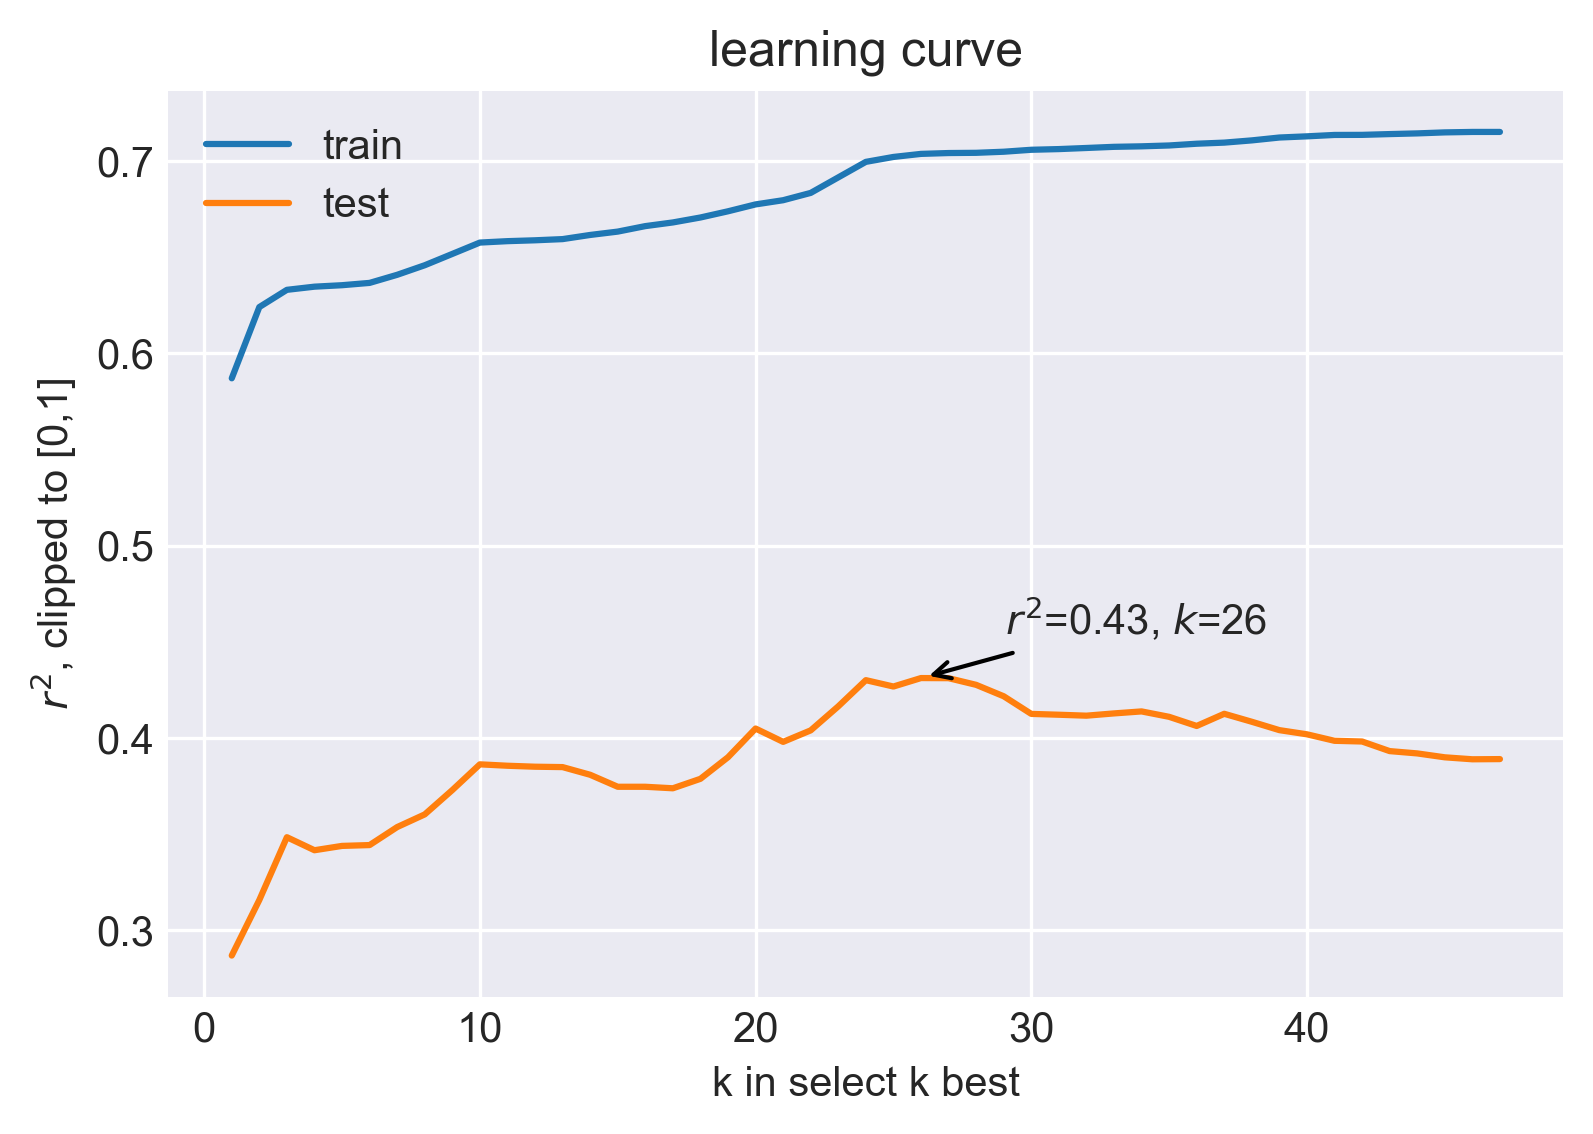

In [9]:
plt.rcParams['figure.dpi'] = 300
sns.set_style("darkgrid")
# figsize(15, 8)

train_scores = []
test_scores = []
# define feature range
num_feats = len(x_master.columns)
feat_range = np.arange(num_feats)+1
# for each k in feat_range
for num_f in feat_range:
    # set pipeline params
    new_pipe_brian.set_params(select__k=num_f)
    # get cross val scores
    cv_result = model_selection.cross_validate(
        new_pipe_brian, X=x_master, y=y_master, cv=10, return_train_score=True)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))

# plot test vs train
plot(feat_range, train_scores, label="train")
plot(feat_range, test_scores, label="test")

# find index of best score
best_i = np.argmax(test_scores)
# annotate score
ann_xy = (feat_range[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $k$={feat_range[best_i]}"
annotate(ann_text, xy=ann_xy, xytext=(.6,.4), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )

xlabel("k in select k best")
ylabel("$r^2$, clipped to [0,1]")
title("learning curve")
legend();

In [10]:
#26 is Best -
brian_pipe = pipeline.Pipeline(
[("std", preprocessing.StandardScaler()), #scale the data
 ("select", feature_selection.SelectKBest
  ( score_func=feature_selection.f_regression,k=26)
 ),
 ("lin", linear_model.LinearRegression())     #linear regression, already normalized
]
)
X_train, X_test, y_train, y_test = model_selection.train_test_split\
(x_master, y_master, test_size=0.25)
brian_pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('select', SelectKBest(k=26, score_func=<function f_regression at 0x10fb778c8>)), ('lin', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [11]:
brian_pipe.score(X_test,y_test)
#Pretty good test scores when using the K#features recommended (26)

0.6130082664153154

In [12]:
#Let's run this against the whole data set and calculate r^2 for real

In [13]:
# master_df_x_copy is our backup dataframe

In [14]:
master_df_x_copy["log_predict_pipe1"] = brian_pipe.predict(x_master)

In [15]:
y_avg = np.mean(master_df_x_copy["LOG_DPY"])

In [16]:
#function will calculate R^2 by hand for our predict results
def calc_r2_by_hand(dataframe):
    y_avg = np.mean(dataframe["LOG_DPY"])
    dataframe["numerator"] = (dataframe["log_predict_pipe1"] - dataframe["LOG_DPY"])**2
    # master_df_x_copy["numerator"]

    dataframe["denominator"] = (dataframe["LOG_DPY"] - y_avg)**2
    # master_df_x_copy["denominator"]


    numerator = dataframe["numerator"].sum()
    denominator = dataframe["denominator"].sum()

    r_squared = 1 - (numerator/denominator)
    print(f"R2: {r_squared}")
    return r_squared

In [17]:
pipe=brian_pipe
def score_test(dataframe,pipe):
    dataframe["log_predict_pipe1"] = pipe.predict(x_master)
    return dataframe

In [18]:
master_df_x_copy = score_test(master_df_x_copy,pipe=brian_pipe)
calc_r2_by_hand(master_df_x_copy)

R2: 0.6999330275438527


0.6999330275438527

In [19]:
#.69 is good, we'll now want to know what coefficients are at play here

In [20]:
feat_support =brian_pipe.named_steps["select"].get_support()
feat = x_master.columns[feat_support]
coef = brian_pipe.named_steps["lin"].coef_

In [21]:
coefficients_features = pd.DataFrame(list(zip(feat, coef)))
coefficients_features.head(10)

,0,1
0,PA_x,-3.148576
1,OBP,1.160257
2,SLG,2.174992
3,OPS,-2.317052
4,ISO,0.024256
5,wRC,0.397723
6,wRAA,1.119595
7,wOBA,-1.133392
8,wRC+,0.480239
9,G,-0.130774


In [22]:
coefficients_features.columns = ["Coefficient","log_effect"]

In [23]:
coefficients_features["true_effect"] = ((10**coefficients_features["log_effect"]) \
                                        - 1) / 100

In [35]:
coefficients_features= coefficients_features.sort_values(by="log_effect",ascending=False)

In [36]:
coefficients_features.head(5)

,Coefficient,log_effect,true_effect
10,AB,4.960482,913.013508
2,SLG,2.174992,1.486209
12,1B,1.311308,0.194790
1,OBP,1.160257,0.134630
6,wRAA,1.119595,0.121703


''

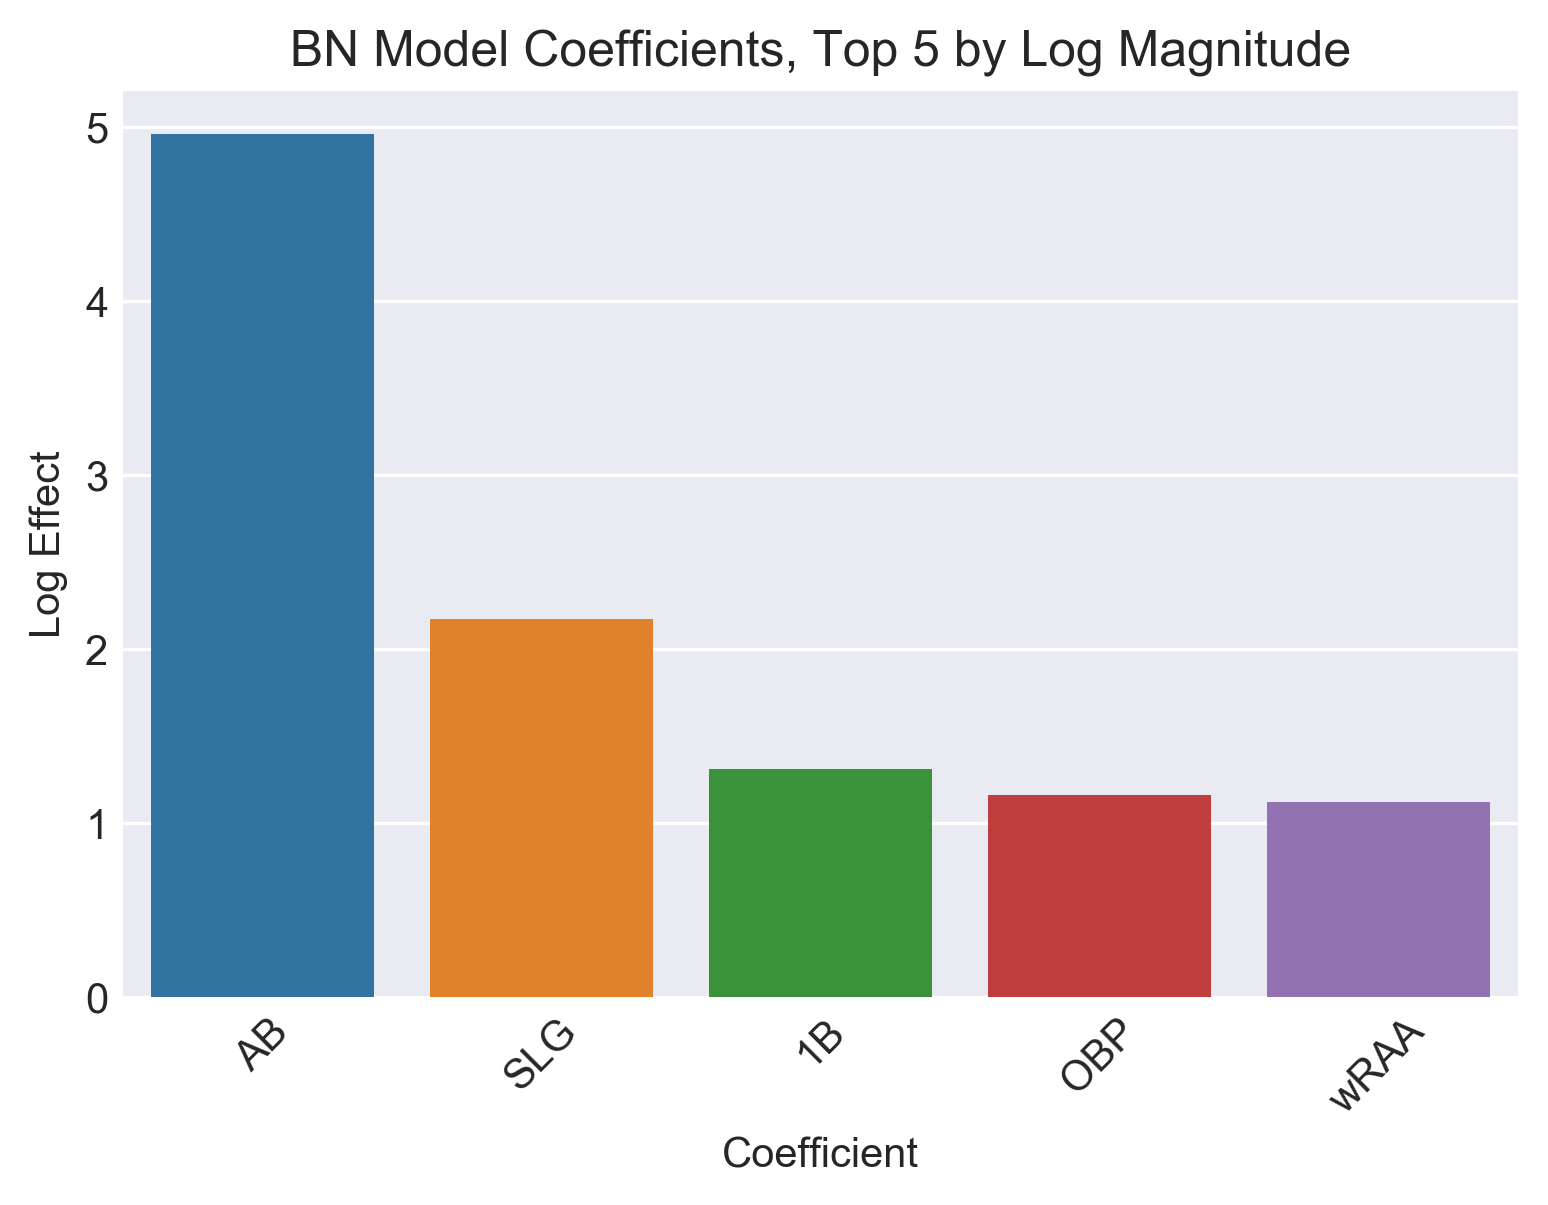

In [47]:
sns.barplot(x="Coefficient",y="log_effect",data=coefficients_features.head(5))
plt.xticks(rotation=45)
plt.ylabel("Log Effect")
plt.title("BN Model Coefficients, Top 5 by Log Magnitude")
plt.savefig("Coefficients_LOG")
;

''

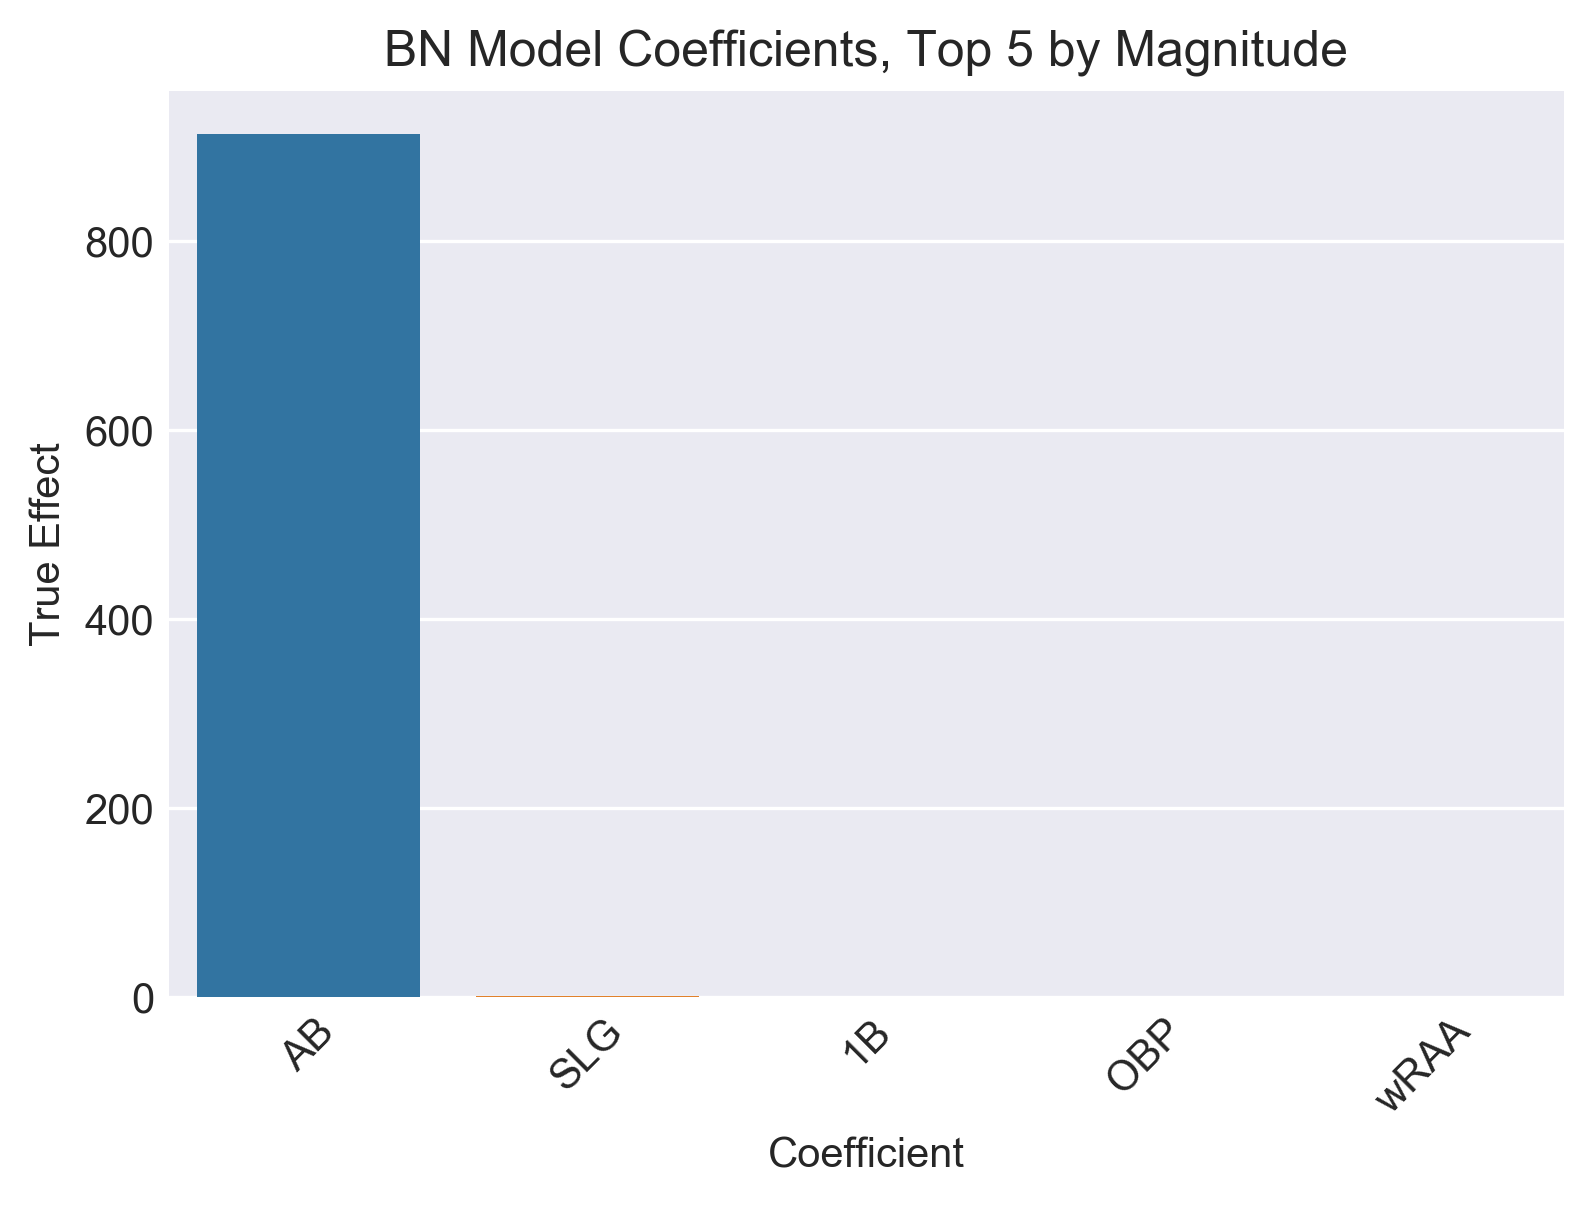

In [48]:
sns.barplot(x="Coefficient",y="true_effect",data=coefficients_features.head(5))
plt.xticks(rotation=45)
plt.ylabel("True Effect")
plt.title("BN Model Coefficients, Top 5 by Magnitude")
plt.savefig("Coefficients_TRUE")
;

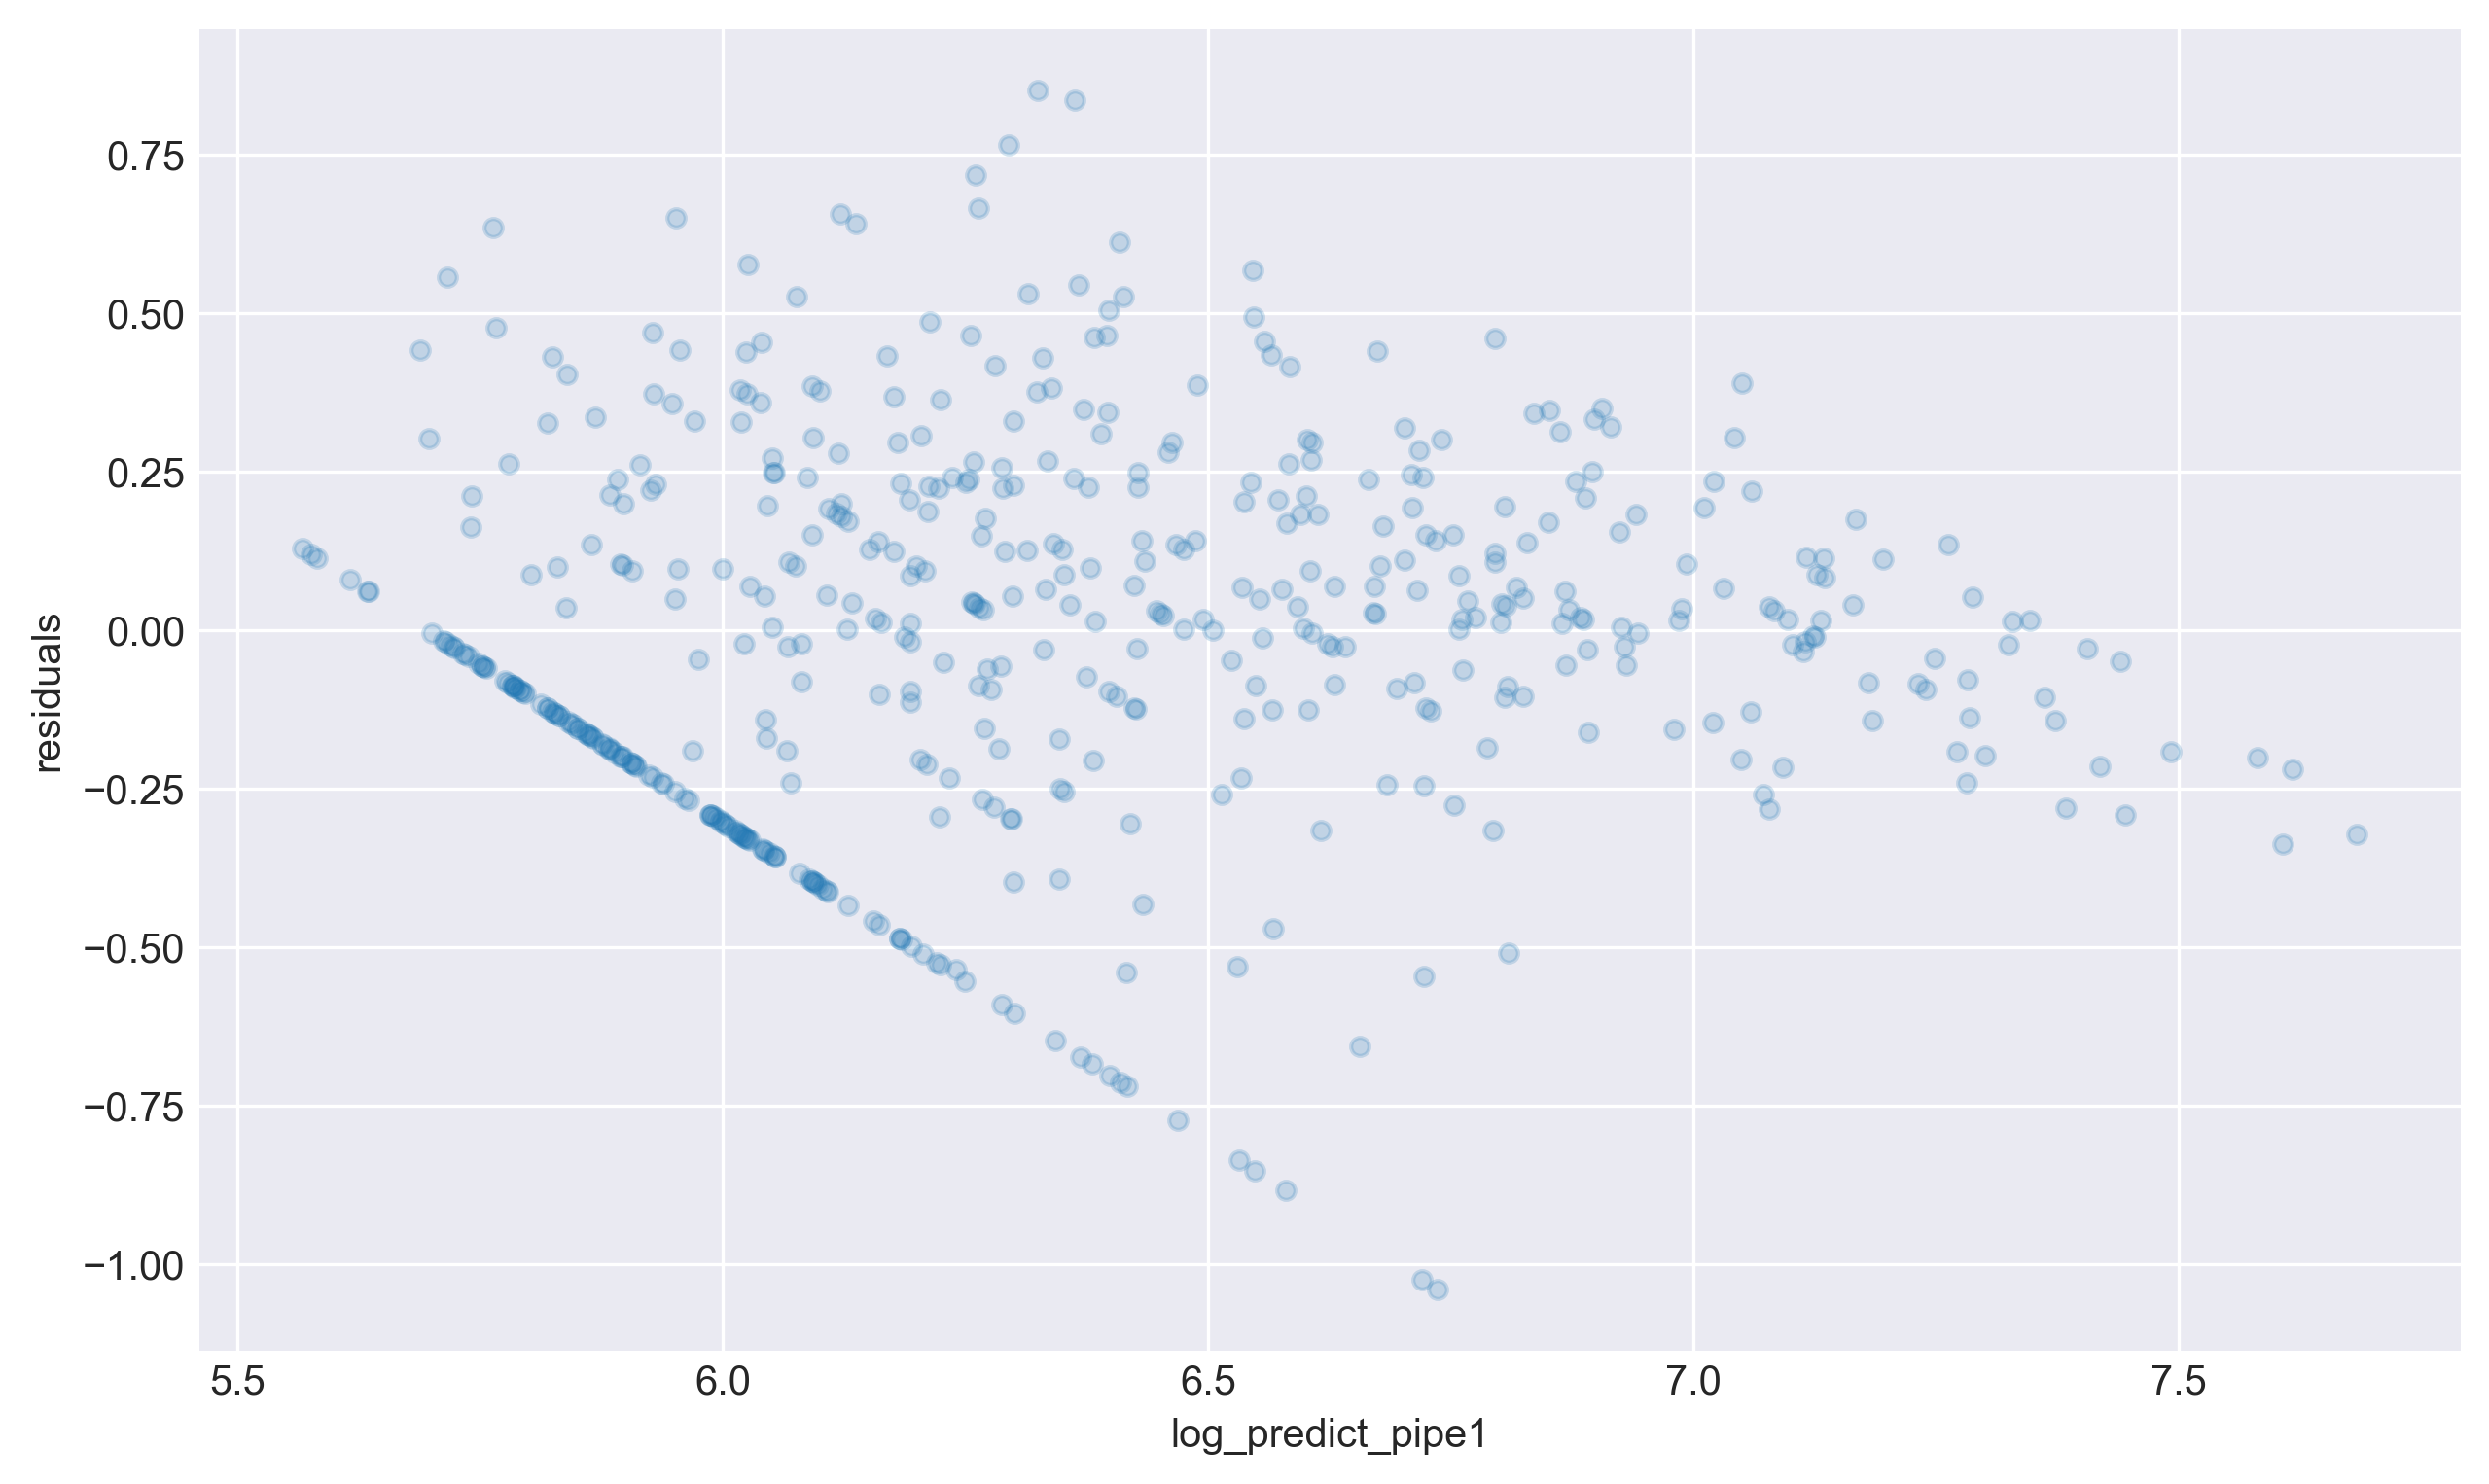

In [25]:
#Plotting Predicted Values vs Residuals
master_df_x_copy["residuals"] = master_df_x_copy["LOG_DPY"]-master_df_x_copy["log_predict_pipe1"]
with sns.axes_style('darkgrid'):
    plot=master_df_x_copy.plot(kind='scatter',
                  x='log_predict_pipe1',y='residuals',alpha=0.2,figsize=(10,6))


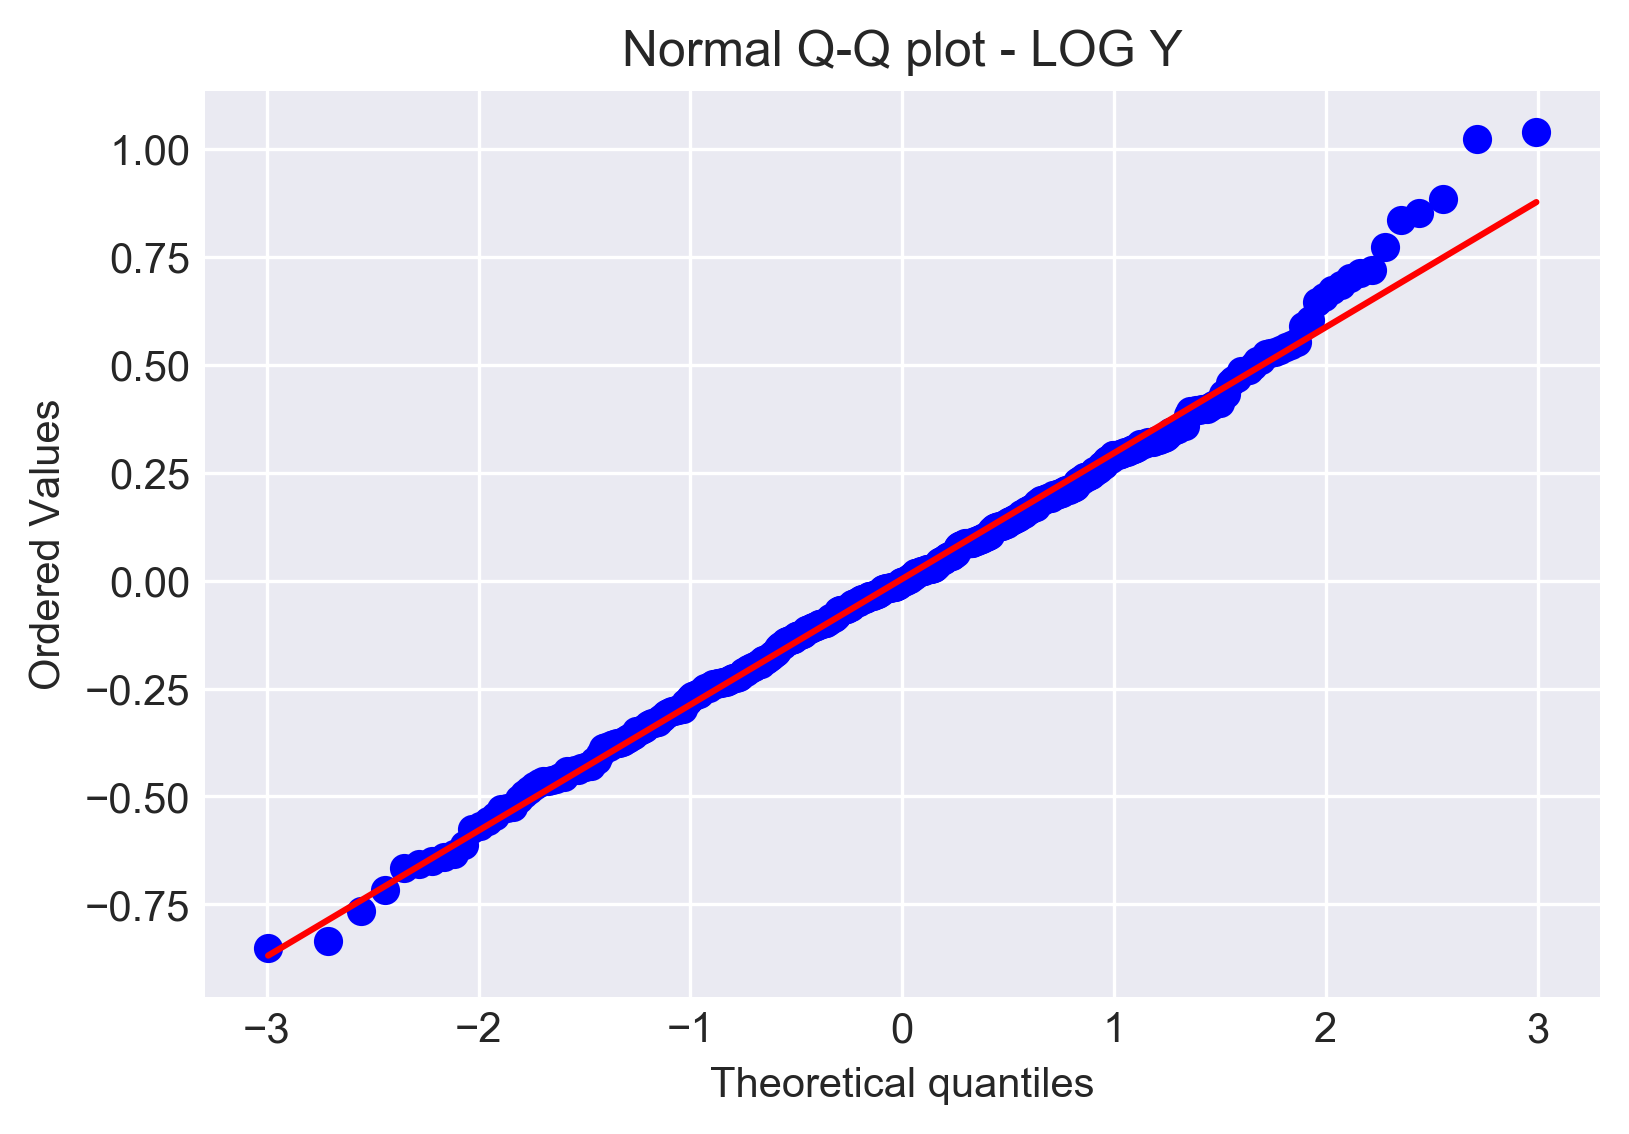

In [26]:
stats.probplot(master_df_x_copy['log_predict_pipe1']-master_df_x_copy['LOG_DPY']\
               , dist="norm", plot=plt)
plt.title("Normal Q-Q plot - LOG Y")
plt.show()
plt.savefig("Normal QQ LOG Y")

Young Guns is our dataframe that will have data for Michael Conforto and Joe Panik, our agent's two young clients. We'll then run predictions just on them

In [27]:
young_guns_df = full_MLB_df[(full_MLB_df["PLAYER_YEAR"]=='Michael Conforto 2017')|\
                          (full_MLB_df["PLAYER_YEAR"]=='Joe Panik 2017')]

In [28]:
young_guns_df.columns

Index(['PLAYER_YEAR', 'PA_x', 'BB%', 'K%', 'BB/K', 'AVG_x', 'OBP', 'SLG',
       'OPS', 'ISO', 'Spd', 'BABIP', 'UBR', 'wGDP', 'wSB', 'wRC', 'wRAA',
       'wOBA', 'wRC+', 'G', 'AB', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI',
       'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'Batting',
       'Base Running', 'Fielding', 'Positional', 'Offense', 'Defense',
       'League', 'Replacement', 'RAR', 'WAR', 'Dollars'],
      dtype='object')

In [29]:
young_guns_df = young_guns_df.set_index(keys="PLAYER_YEAR")

In [30]:
#Running the prediction pipeline on our young_guns_df (MC and JP)

In [31]:
young_guns_df["pred_salaries_log"] = brian_pipe.predict(young_guns_df)

In [32]:
young_guns_df["pred_salaries_yearly"] = ((10**young_guns_df["pred_salaries_log"]))

In [33]:
young_guns_df

,PA_x,BB%,K%,BB/K,AVG_x,OBP,SLG,OPS,ISO,Spd,...,Positional,Offense,Defense,League,Replacement,RAR,WAR,Dollars,pred_salaries_log,pred_salaries_yearly
PLAYER_YEAR,,,,,,,,,,,,,,,,,,,,,
Michael Conforto 2017,440,13.0,25.7,0.50,0.279,0.384,0.555,0.939,0.276,3.6,...,-2.1,29.1,0.2,0.6,13.6,43.5,4.3,34.6,7.191855,1.555448e+07
Joe Panik 2017,573,8.0,9.4,0.85,0.288,0.347,0.421,0.768,0.133,4.2,...,2.0,0.8,0.9,0.8,17.7,20.2,2.0,16.1,6.518841,3.302484e+06


These numbers make sense with our understanding of MLB salaries. Conforto getting 17 million per year fits with his growing superstar role, while Panik is likely a bit undervalued by our model as his youth and hitting prowess for a 2nd baseman should be better valued in the market.

In [34]:
with open('young_guns_df.pkl', 'wb') as picklefile:
    pickle.dump(young_guns_df, picklefile)